In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st
from datetime import datetime, timedelta
import datetime as dt
from plotly import graph_objects as go
import math as mth

# Космические братья» — формирование модели монетизации

# Описание проекта

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

Цель: 
1. Проведем исследовательский анализ данных. 
2. Проанализируем влияние событий на совершение целевого события.
3. Проверим статистические гипотезы:
- различие времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком;
- динамика строительства зданий у клиентов с вероятностью ухода и в среднем по остальной выборке..

## Обзор и предобработка данных

In [2]:
costs = pd.read_csv('/datasets/ad_costs.csv')
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [3]:
game = pd.read_csv('/datasets/game_actions.csv')
game.info()
game.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [4]:
users = pd.read_csv('/datasets/user_source.csv')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


### Поиск пропусков и дубликатов

In [5]:
game.isna().sum()

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

In [6]:
print('Количество дубликатов до удаления:', game.duplicated().sum())
game = game.drop_duplicates()
print('Количество дубликатов после удаления:', game.duplicated().sum())

Количество дубликатов до удаления: 1
Количество дубликатов после удаления: 0


In [7]:
costs.duplicated().sum()

0

In [8]:
users.duplicated().sum()

0

При обзорре обнаружены пропуски в таблице game, в столбцах building_type и project_type.

При поиске дубликатов, был найден всего один дубликат в той же таблице.

Остальные данные выглядят нормально.

### Приведение к нужным типам данных

In [9]:
game['event_datetime'] = pd.to_datetime(game['event_datetime'])
game['date'] = pd.to_datetime(game['event_datetime'].dt.date)
game['day'] = pd.to_datetime(game['event_datetime'].dt.day)
game.head()
game.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
 5   date            135639 non-null  datetime64[ns]
 6   day             135639 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(4)
memory usage: 8.3+ MB


In [10]:
costs = costs.rename(columns={'day':'date'})
costs['date'] = pd.to_datetime(costs['date'])
costs.head()

,source,date,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


### Обработаем пропуски

#### Колонка building_type

In [11]:
omis_bt=game[game['building_type'].isnull()]
omis_bt.describe()

/tmp/ipykernel_120/3023694967.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  omis_bt.describe()
/tmp/ipykernel_120/3023694967.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  omis_bt.describe()
/tmp/ipykernel_120/3023694967.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  omis_bt.describe()


,event_datetime,event,building_type,user_id,project_type,date,day
count,7683,7683,0,7683,1866,7683,7683
unique,7663,2,0,5817,1,33,31
top,2020-05-12 11:55:56,finished_stage_1,NaN,1f71fdae-2afd-4dcc-8734-7ff7fb0939dc,satellite_orbital_assembly,2020-05-16 00:00:00,1970-01-01 00:00:00.000000016
freq,2,5817,NaN,2,1866,856,856
first,2020-05-04 19:47:29,NaN,NaN,NaN,NaN,2020-05-04 00:00:00,1970-01-01 00:00:00.000000001
last,2020-06-05 12:32:49,NaN,NaN,NaN,NaN,2020-06-05 00:00:00,1970-01-01 00:00:00.000000031


Вс столбце event только два уникальных значения, посмотрим них

In [12]:
omis_bt['event'].unique() 

array(['finished_stage_1', 'project'], dtype=object)

In [13]:
game.loc[game['project_type'].isna() &
                 (game['event'] == 'finished_stage_1'),
                 'project_type'] = 'finish_game'

In [14]:
game.loc[game['project_type'].isna(), 'project_type'] = 'not_finish_game'

In [15]:
game['building_type'] = game['building_type'].fillna('no_buildings')

В данных имеются только значения finished_stage_1 и project, подсчитаем их количество по датасету в целом:

In [16]:
fs_len=len(game[game['event'] == 'finished_stage_1'])
pr_len=len(game[game['event'] == 'project'])
fs_len+pr_len

7683

Пропуски в колонке building_type обусловлены тем, что для событий finished_stage_1 и project не происходит строительства какого-либо здания, а соответственно с этими пропусками ничего делать не будем.

#### Колонка project_type 

Повторим те же действия 

In [17]:
omis_pr=game[game['project_type'].isnull()]
omis_pr.describe()

,event_datetime,event,building_type,user_id,project_type,date,day
count,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
omis_pr['event'].unique()

array([], dtype=object)

Видим, что для данной выборки отсутствует значение project, посмотим их количество в общем датасете:

In [19]:
pr_len

1866

Значение project в колонке event полностью соответствует заполненным данным с типом проекта satellite_orbital_assembly, соответственно данные верны и обработка пропусков не требуется.

### Вывод:

- Изменены форматы данных времени на datetime
- Добавлен столбец с датой сессии 'date'
- Удалены дубликаты 
- Пропуски обрабатывать нет необходимости

Данные изучены можно приступать к анализу

## Иследовательский анализ

### Количество игроков по типам событий

In [20]:
gamers_type = game.groupby('event').agg({'user_id':'nunique'}).reset_index()
gamers_type

,event,user_id
0,building,13576
1,finished_stage_1,5817
2,project,1866


,user_id
date,
2020-05-04,5860
2020-05-05,6382
2020-05-06,6854
2020-05-07,7384
2020-05-08,7891


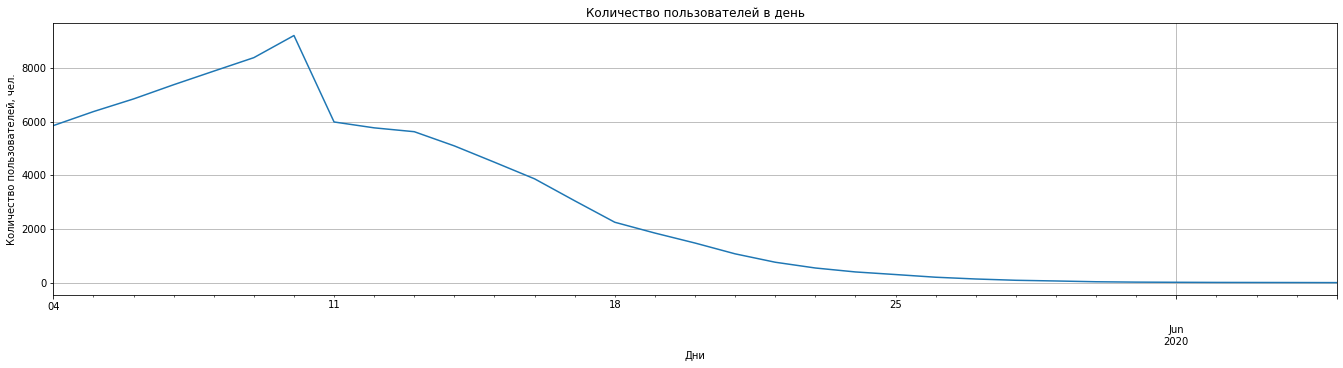

In [21]:
dau_total = game.groupby('date').agg({'user_id': 'nunique'})
display(dau_total.head())
dau_total.plot(grid=True, title='Количество пользователей в день', figsize=(23, 5),legend=False)
plt.gca().set(xlabel='Дни', ylabel='Количество пользователей, чел.')
plt.show()
     

In [22]:
dau_total.describe()

,user_id
count,33.000000
mean,2884.878788
std,3083.784493
min,4.000000
25%,91.000000
50%,1480.000000
75%,5776.000000
max,9219.000000


В выборке отмечаем увеличение количества пользователей в день до 2020-05-10 в размере до 9219 человек, но 11 мая 2020 произошел резкий спад количества игроков. Возможно из - за окончания выходных, а возможно из - за окончания рекламной компании, которая проводилась:

In [23]:
print('с {:%d.%m.%Y} по {:%d.%m.%Y}'.format(costs['date'].min(), costs['date'].max()))

с 03.05.2020 по 09.05.2020


### График отображающий количество событий по дням

,event
date,
2020-05-04,8171
2020-05-05,9055
2020-05-06,9925
2020-05-07,10858
2020-05-08,12059


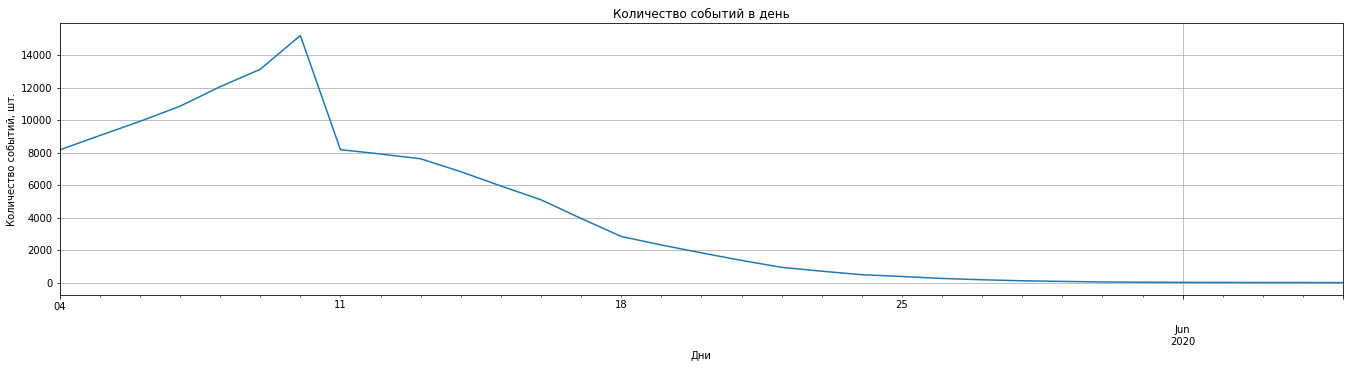

In [24]:
dau_total_events = game.groupby('date').agg({'event': 'count'})
display(dau_total_events.head())

dau_total_events.plot(grid=True, title='Количество событий в день', figsize=(23, 5),legend=False)
plt.gca().set(xlabel='Дни', ylabel='Количество событий, шт.')
plt.show()

In [25]:
dau_total_events.describe()

,event
count,33.000000
mean,4110.272727
std,4639.714311
min,5.000000
25%,118.000000
50%,1837.000000
75%,7918.000000
max,15207.000000


График количества событий коррелирует с графиком количества пользователей в день - до 2020-05-10 достигает 15 207 событий, но к 2020-06-05 этот показатель снижается до 5.

### Среднеее количетсво событий на пользователя

In [26]:
events_per_user=game.groupby('user_id').agg({'event': 'count'}).mean()
print(f'{int(events_per_user)} событий')

9 событий


### График распределения количества построенных объектов

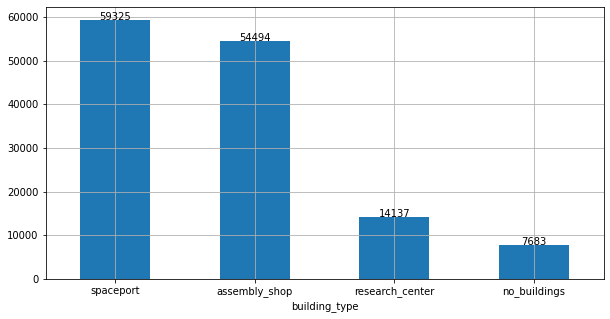

In [27]:
events_by_building_type=game.groupby('building_type')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)

ax=events_by_building_type.plot(x='building_type', y='user_id', kind='bar', grid=True, figsize=(10, 5), rot=360)
ax.get_legend().remove()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 5,
            '{:.0f}'.format(height),
            fontsize=10,
            ha="center")
plt.show()

Больше всего было построено spaceport, за ними идут assembly_shop, research_center строят в разы меньше.

### Среднее количество построенных зданий в трех группах пользователей:

 - завершивших проект:

In [28]:
events_pr=game.query('event=="project"')
users_pr=events_pr['user_id'].unique()
round(game[game['user_id'].isin(users_pr)].groupby('user_id').agg({'building_type': 'count'}).mean(),2)

building_type    14.65
dtype: float64

- победивших врага:

In [29]:
events_fs=game.query('event=="finished_stage_1"')
users_fs=events_fs['user_id'].unique()
round(game[game['user_id'].isin(users_fs)].groupby('user_id').agg({'building_type': 'count'}).mean(),2)

building_type    11.77
dtype: float64

- не прошедших первый уровень:

In [30]:
events_not_win=game[~game['user_id'].isin(users_fs)][~game[~game['user_id'].isin(users_fs)]['user_id'].isin(users_pr)]
users_not_win=events_not_win['user_id'].unique()
round(game[game['user_id'].isin(users_not_win)].groupby('user_id').agg({'building_type': 'count'}).mean(),2)

building_type    8.66
dtype: float64

### Построим график, отображающий количество пользователей, пришедших из разных рекламных источников

Для начала добавим в датасет source дату первого входа в игру - first_enter:

In [31]:
first_enter = game.groupby(['user_id'])['date'].min()
first_enter.name = 'first_enter'
users = users.join(first_enter,on='user_id')
users.head()

,user_id,source,first_enter
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,2020-05-06
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,2020-05-05
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,2020-05-05


Подсчитаем количество пользователей по каждому источнику рекламы:

In [32]:
users_per_source=users.groupby(['source']).agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending=False)
users_per_source.columns=['source', 'users_number']
users_per_source.head()

,source,users_number
2,yandex_direct,4817
1,instagram_new_adverts,3347
0,facebook_ads,2726
3,youtube_channel_reklama,2686


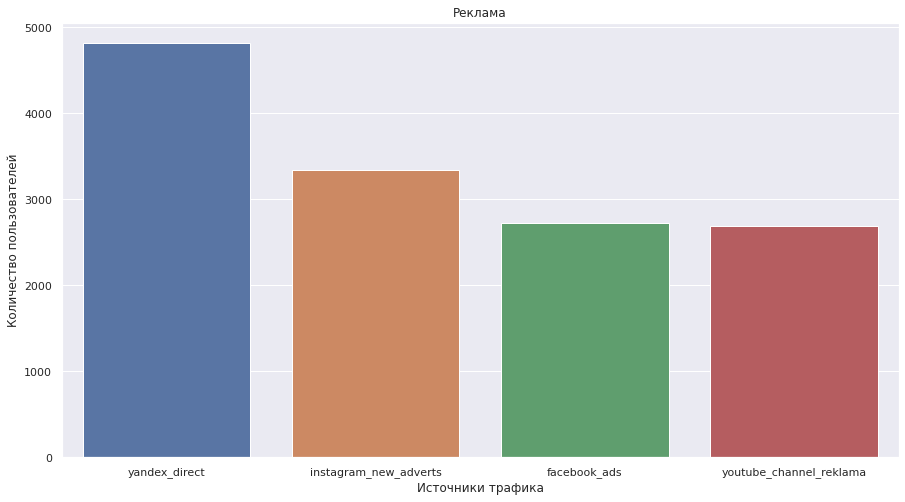

In [33]:
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.barplot(x='source', y='users_number', data=users_per_source)
ax.set_title('Реклама')
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Источники трафика')
old_ticks, old_labels = plt.xticks()
plt.xticks(old_ticks, ['\n'.join(label.get_text().split()) for label in old_labels], rotation=0)
plt.show()

Большинство пользователей пришли из yandex_direct.

### Суммарные траты на рекламу

In [34]:
print('Всего трат -', round(costs['cost'].sum(),2))

Всего трат - 7603.58


### Сколько стоило привлечение одного покупателя из каждого источника?

In [35]:
# Подсчитаем количество пользователей по дате первого входа в игру и источнику рекламы:
users_date_source=users.groupby(['first_enter', 'source']).agg({'user_id': 'nunique'}).reset_index() 
users_date_source.columns=['first_enter','source', 'users_number']
users_date_source.head()
# Переведем столбец с датой в соответствующий формат:
users_date_source['first_enter'] = users_date_source['first_enter'].astype('datetime64[s]')
# Cоздадим дополнительный столбец для выравнивания дат:
users_date_source['shifted_date'] = users_date_source['first_enter'] - pd.Timedelta(days=1)
# Объединим полученный датасет с данными по затратам:
costs = pd.merge(costs, users_date_source,  how='left', left_on=['date','source'], right_on = ['shifted_date','source'])
# Сгруппируем данные по источнику рекламы и просуммируем затраты и количество пользователей:
costs_source=costs.groupby('source').agg({'cost':'sum', 'users_number':'sum'}).reset_index()
# Теперь рассчитаем CAC по рекламному источнику:
costs_source['cost_per_user'] = costs_source['cost'] / costs_source['users_number']
costs_source

,source,cost,users_number,cost_per_user
0,facebook_ads,2140.904643,2726,0.785365
1,instagram_new_adverts,2161.441691,3347,0.645785
2,yandex_direct,2233.111449,4817,0.463590
3,youtube_channel_reklama,1068.119204,2686,0.397662


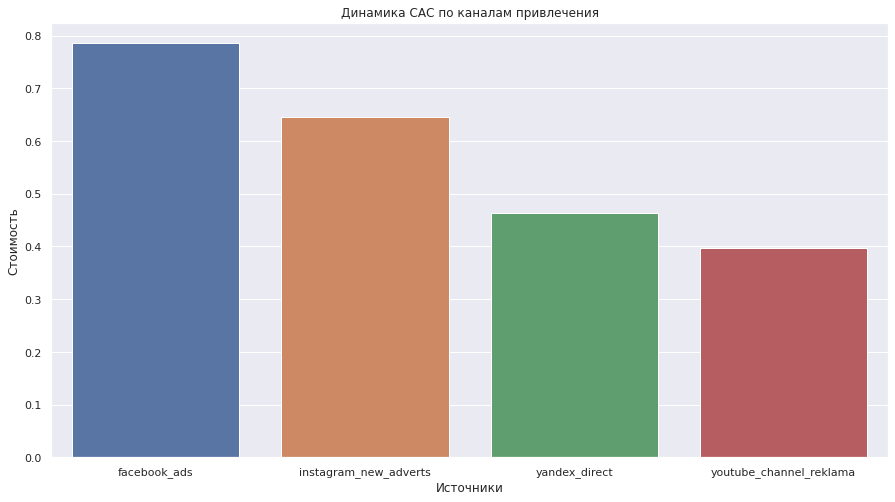

In [36]:
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.barplot(x='source', y='cost_per_user', data=costs_source)
ax.set_title('Динамика САС по каналам привлечения')
ax.set_ylabel('Стоимость')
ax.set_xlabel('Источники')
old_ticks, old_labels = plt.xticks()
plt.xticks(old_ticks, ['\n'.join(label.get_text().split()) for label in old_labels], rotation=0)
plt.show()

Диапазон затрат на привлечение 1 пользователя разнится от 0,40 до 0,79, самым выгодным источником является youtube_channel_reklama.

### Вывод:

- Рекодрное количество игроков в день - 9219, но 11 мая начался резкий спад. Возможно из-за окончания рекламной компании.
- Максимальное количетсво событий - 15208, но затем снижается до 5.
- В среднем на одного пользователя приходится 9 событий.
- Больше всего строят spaceport.
- Наименьшее количнество построек наблюдается в группе "не прошедших первый уровень".
- Суммарные затраты на рекламу составили: 7603.58.
- Самым дешевым источником рекламы оказался youtube_channel_reklama.
- Больше всего пользователей пришли из yandex_direct.

## Проверим гипотезы

### Различие времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком

Выведем в отдельную колонку разницу во времени с момента начала игры и до момента прохождения 1го уровня.

для этого расчитаем время:

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


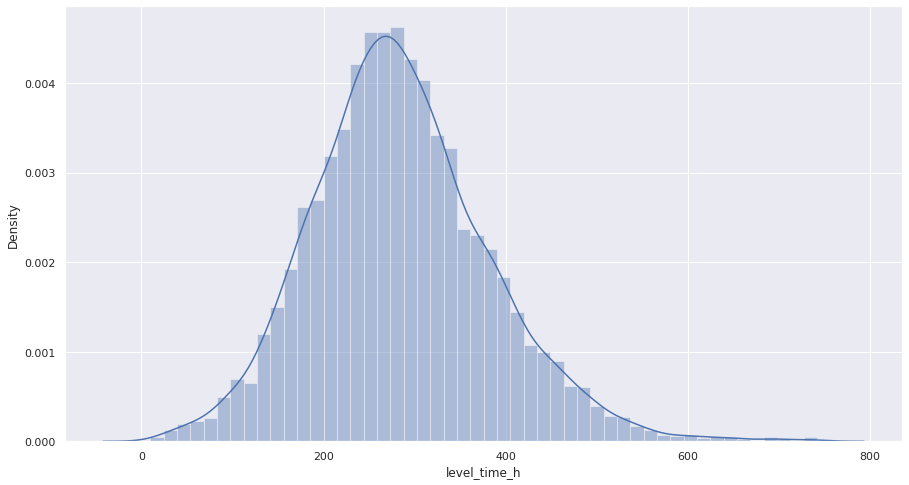

In [37]:
user_filter = game[game['project_type'] != 'not_finish_game']['user_id']
level_time = (game
              .query('user_id in @user_filter')
              .groupby('user_id')
              .agg({'event_datetime':['min','max']}))
level_time['level_time'] = level_time[('event_datetime', 'max')] - level_time[('event_datetime', 'min')]
level_time.columns = level_time.columns.droplevel(1)
level_time = level_time.reset_index().sort_values(by='level_time')
level_time.head()
level_time['level_time_h'] = level_time['level_time'] / np.timedelta64(1, 'h')
sns.distplot(level_time['level_time_h'])
plt.show()

In [38]:
# получим пользователей одержавших победу
user_finish = game[(game['project_type'] != 'not_finish_game')][['user_id', 'project_type']]
# получим пользователей одержавших победу через строительство
user_project = game[game['project_type'] == 'satellite_orbital_assembly'][['user_id', 'project_type']]
# получим пользователей одержавших победу над игроком
user_fight = user_finish[~user_finish.isin(user_project['user_id'].unique())].dropna()
# добавим данные c бойцами и строителями к таблице
level_passing_time_project = level_time[['user_id', 'level_time_h']].merge(user_project, how='left', on='user_id').dropna()
level_passing_time_user_fight = level_time[['user_id', 'level_time_h']].merge(user_fight, how='left', on='user_id').dropna()
# разделим таблицу на 2 по типу проекта
victory_over_enemy = level_passing_time_user_fight['level_time_h']
satellite_orbital_assembly = level_passing_time_project['level_time_h']
display(satellite_orbital_assembly)
victory_over_enemy

210     123.374167
228     127.371111
274     134.270278
276     134.403889
314     139.484722
           ...    
5802    646.824167
5806    661.009444
5807    687.631944
5808    689.624444
5811    699.228611
Name: level_time_h, Length: 1866, dtype: float64

0         9.650278
1        19.568889
2        19.734444
3        22.623333
4        24.302222
           ...    
5812    702.478333
5813    727.772500
5814    729.606667
5815    741.203611
5816    741.981389
Name: level_time_h, Length: 3951, dtype: float64

<div class="alert alert-info"> <b>Комментарий студента:</b> Для ревью: </div>

Воспользуемся T-тестом для разности двух средних.

H0: Время прохождения одинаково

H1: Время прохождения различно

In [39]:
 #задаем уровень статистической значимости
alpha = .05

results = st.ttest_ind(
    satellite_orbital_assembly, 
    victory_over_enemy)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('\nСреднее значения времени прохождения уровня \nPvP - {}\nСтроительство орбитальнойстанции - {}\nРазница - {}'
      .format(level_passing_time_user_fight['level_time_h'].mean().round(2),
              level_passing_time_project['level_time_h'].mean().round(2),
              (level_passing_time_project['level_time_h'].mean() -
              level_passing_time_user_fight['level_time_h'].mean()).round(2)))

p-значение: 7.256845329495443e-98
Отвергаем нулевую гипотезу

Среднее значения времени прохождения уровня 
PvP - 266.51
Строительство орбитальнойстанции - 323.01
Разница - 56.51


Скорость прохождения уровня зависит от способа/

### Динамика строительства зданий у клиентов с вероятностью ухода и в среднем по остальной выборке

Для проверки этой гипотезы нужно сперва обозначить пользователей, которые с большой долей вероятности прекратят пользоваться игрой.

Основной активностью в игре является постройка зданий. Сперва сгруппируем данные по когорте first_enter и дате постройки зданий session_date:

In [40]:
events = game.join(first_enter,on='user_id')

In [41]:
buildings_grouped_by_cohorts = events.query('event=="building"').groupby(
    ['first_enter', 'date']
).agg({'user_id': 'nunique', 'event': 'count'}).reset_index()
buildings_grouped_by_cohorts.columns=['first_enter', 'date','users_number', 'events_number']
# Определим среднее количество построек у одного пользователя 
buildings_grouped_by_cohorts['buildings_per_user'] = (
    buildings_grouped_by_cohorts['events_number']
    / buildings_grouped_by_cohorts['users_number']
)
buildings_grouped_by_cohorts.head()

,first_enter,date,users_number,events_number,buildings_per_user
0,2020-05-04,2020-05-04,5860,8170,1.394198
1,2020-05-04,2020-05-05,3020,4332,1.434437
2,2020-05-04,2020-05-06,3203,4709,1.470184
3,2020-05-04,2020-05-07,3411,5075,1.487833
4,2020-05-04,2020-05-08,3557,5640,1.585606


Найдём lifetime когорты. Из даты постройки здания date вычтем дату когорты first_enter:

In [42]:
buildings_grouped_by_cohorts = buildings_grouped_by_cohorts
buildings_grouped_by_cohorts['cohort_lifetime'] = (
    (buildings_grouped_by_cohorts['date']
    - buildings_grouped_by_cohorts['first_enter'])/ np.timedelta64(1, 'D')
)
buildings_grouped_by_cohorts['cohort_lifetime'] = buildings_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
buildings_grouped_by_cohorts.head()

,first_enter,date,users_number,events_number,buildings_per_user,cohort_lifetime
0,2020-05-04,2020-05-04,5860,8170,1.394198,0
1,2020-05-04,2020-05-05,3020,4332,1.434437,1
2,2020-05-04,2020-05-06,3203,4709,1.470184,2
3,2020-05-04,2020-05-07,3411,5075,1.487833,3
4,2020-05-04,2020-05-08,3557,5640,1.585606,4


Построим сводную таблицу изменения среднего количества построенных зданий, где в столбцах будет lifetime, а строках — когорты:

In [43]:
buildings_per_user_pivot = buildings_grouped_by_cohorts.pivot_table(
    index='first_enter',
    columns='cohort_lifetime',
    values='buildings_per_user',
    aggfunc='mean',
)
buildings_per_user_pivot.head()

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
first_enter,,,,,,,,,,,,,,,,,,,,,
2020-05-04,1.394198,1.434437,1.470184,1.487833,1.585606,1.617254,1.688544,1.382543,1.357322,1.310592,...,1.142857,1.095238,1.058824,1.375,1.25,1.0,1.0,NaN,1.0,1.0
2020-05-05,1.404344,1.479201,1.480547,1.522141,1.564767,1.653461,1.357834,1.357481,1.337662,1.280067,...,1.062500,1.083333,1.000000,1.200,1.00,1.0,1.0,NaN,NaN,NaN
2020-05-06,1.377910,1.478125,1.485236,1.531839,1.680624,1.324873,1.360149,1.323037,1.317972,1.278571,...,1.000000,1.000000,1.250000,1.500,1.00,1.0,1.0,NaN,1.0,NaN
2020-05-07,1.385933,1.486631,1.530278,1.552870,1.276850,1.294785,1.328685,1.334129,1.301724,1.253333,...,1.285714,1.400000,1.000000,1.000,1.00,1.0,1.0,1.0,NaN,NaN
2020-05-08,1.335756,1.432024,1.478378,1.256410,1.232558,1.255319,1.387205,1.283401,1.254335,1.256158,...,1.000000,1.500000,1.000000,NaN,1.00,NaN,NaN,NaN,NaN,NaN


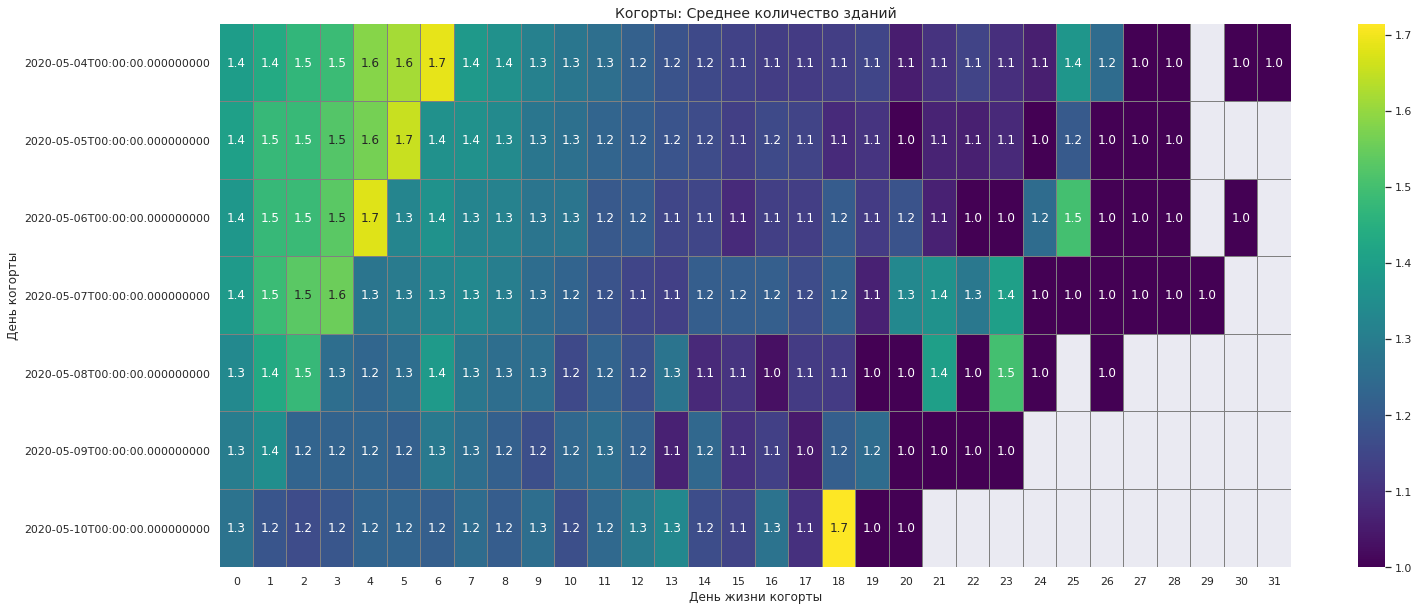

In [44]:
sns.set(style='dark')
plt.figure(figsize=(24, 10))
plt.title('Когорты: Среднее количество зданий', size=14)
ax=sns.heatmap(buildings_per_user_pivot, annot=True, fmt='.1f', linewidths=.01, linecolor='gray', cmap="viridis")
ax.set_ylabel('День когорты')
ax.set_xlabel('День жизни когорты')
plt.show()

Максимальное среднее количество простроенных зданий в день - 1,7.

Добавим признак churn по пользователям у которых с даты последнего события прошло от 3 недель и проверим гипотезу.

Найдем последнее событие по каждому пользователю:

In [45]:
last_enter = game.groupby(['user_id'])['date'].max()
last_enter.name = 'last_enter'
last_enter=last_enter.to_frame().reset_index()
last_enter['na_days']=events['date'].max()-last_enter['last_enter']
last_enter['na_days']=last_enter['na_days'].dt.days
last_enter.head()

,user_id,last_enter,na_days
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-20,16
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-18,18
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-14,22
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-12,24
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-22,14


Добавим колонку Churn

In [46]:
def churn_flag(row):
    if row['na_days']>= 21:
        return 1
    return 0
last_enter['churn'] = last_enter.apply(churn_flag, axis=1)

In [47]:
events = events.merge(last_enter,on='user_id')
events.head()

,event_datetime,event,building_type,user_id,project_type,date,day,first_enter,last_enter,na_days,churn
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_finish_game,2020-05-04,1970-01-01 00:00:00.000000004,2020-05-04,2020-05-10,26,1
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_finish_game,2020-05-05,1970-01-01 00:00:00.000000005,2020-05-04,2020-05-10,26,1
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_finish_game,2020-05-05,1970-01-01 00:00:00.000000005,2020-05-04,2020-05-10,26,1
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_finish_game,2020-05-05,1970-01-01 00:00:00.000000005,2020-05-04,2020-05-10,26,1
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_finish_game,2020-05-06,1970-01-01 00:00:00.000000006,2020-05-04,2020-05-10,26,1


Воспользуемся T-тестом для разности двух средних.

H0: Динамика строительства зданий у клиентов с вероятностью ухода и в среднем по выборке одинакова

H1: Динамика строительства зданий у клиентов с вероятностью ухода и в среднем по выборке различна

In [48]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    events.query('churn==0').groupby('user_id').agg({'building_type': 'count'}).reset_index()['building_type'],
    events.query('churn==1').groupby('user_id').agg({'building_type': 'count'}).reset_index()['building_type'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Выдвинутая гипотеза подтвердила различие в динамике строительства зданий у активных пользователей и пользователей попавших в отток.

### Вывод

На основании проведенных тестов можно сказать что:
- Время прохождения уровня не так сильно зависит, от победы или постройки.
- Наблюдается различие в динамике строительства зданий у активных пользователей и пользователей попавших в отток

## Итоговый вывод


1. Учитывая затраты на рекламу и количетсво пришедших игроков, стоит выделить yandex_direct. Так как, по цене он почти самый дешевый, а по количетсву привлеченных пользователей на первом месте.
2. Так как время прохождение уровня в зависимости от способа различно, монетизацию можно интегрировать в постройку для игроков, желающих играть на таких правилах, но с возможностью ускорения строительства за счет монетизации. Но в таком случае нужно будет рассмотреть баланс между PVP и строительством.
3. По типу построек самое популярное это spaceport. Так что в монетизацию можно вшить некоторые донаты связанные с этим типом постройки.